In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

In [2]:
adult = pd.read_csv('adult_with_headers.csv')
adult.sample()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
11340,30,?,288419,5th-6th,3,Married-civ-spouse,?,Husband,White,Male,0,0,40,Mexico,<=50K


In [ ]:
adult.info()

In [ ]:
adult.isna().sum()

In [5]:
adult.duplicated().sum()

24

In [ ]:
adult[adult.duplicated()]

In [ ]:
adult = adult.drop_duplicates()
adult.head()

In [ ]:
adult.describe()

In [ ]:
adult[adult.describe().columns].hist(figsize=(12,12), layout=(3,3), sharex=False);
plt.show()

In [ ]:
!pip install klib

In [ ]:
import klib
for i in adult.describe().columns:
    klib.dist_plot(adult[i])

In [ ]:
!pip install dataprep

In [ ]:
from dataprep.eda import create_report
import pandas as pd
adult=pd.read_csv('adult_with_headers.csv')
create_report(adult)

In [ ]:
adult['capital_diff'] = adult['capital_gain'] - adult['capital_loss']
adult['work_experience'] = adult['age'] - adult['education_num'] - 5
adult.head()

### Why These Features Might Be Beneficial

Capital Difference:

This feature directly represents the financial impact of capital transactions, making it easier for the model to learn whether these transactions have a significant impact on income. It combines two features into one, reducing the complexity the model has to handle.

Work Experience:

Work experience is a critical factor in determining income. More experienced workers are typically paid more, so this feature provides a direct estimate of experience, which might have a strong correlation with income. This feature also helps to contextualize the age and education_num features by showing how they interact to impact income.

In [15]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
sc = StandardScaler()
mm = MinMaxScaler()
le = LabelEncoder()

In [16]:
adult['age'] = sc.fit_transform(adult[['age']])
adult['hours_per_week'] = sc.fit_transform(adult[['hours_per_week']])

In [ ]:
adult['fnlwgt'] = mm.fit_transform(adult[['fnlwgt']])
adult['capital_gain'] = mm.fit_transform(adult[['capital_gain']])
adult['capital_loss'] = mm.fit_transform(adult[['capital_loss']])
adult['education_num'] = mm.fit_transform(adult[['education_num']])
adult.head()

Standard Scaling: 

Standard Scaling is generally used when the features are normally distributed or when the model assumes that the data is centered around zero with unit variance.

Min-Max Scaling: 

Min-Max Scaling is suitable when you want to preserve the original relationships and distributions within a fixed range, which is important in algorithms like neural networks or when the data does not follow a normal distribution.

In [ ]:
list1 = []
for i in adult.select_dtypes('object').columns:
    if adult[i].nunique() > 5:
        adult[i] = le.fit_transform(adult[[i]])
    else:
        list1.append(i)

adult.head()

In [19]:
list1

['race', 'sex', 'income']

In [ ]:
race = pd.get_dummies(adult['race'], drop_first=True)
race.head()

In [21]:
sex = pd.get_dummies(adult['sex'], drop_first=True)
sex.head()

,Male
0,1
1,1
2,1
3,1
4,0


In [22]:
income = pd.get_dummies(adult['income'], drop_first=True)
income.head()

,>50K
0,0
1,0
2,0
3,0
4,0


In [ ]:
adult = pd.concat([adult, race, sex, income], axis=1)
adult.head()

In [ ]:
adult = adult.drop(['race', 'sex', 'income'], axis=1)
adult.head()

#### Pros of One-Hot Encoding:

Easily interpretable results

Efficient for sparse data

Handles non-numeric categorical variables neatly

#### Cons of One-Hot Encoding:

High dimensionality and memory consumption

May lead to the curse of dimensionality

Computationally expensive

#### Pros of Label Encoding:

Easily handle large datasets

Less memory consumption

Quick computation

#### Cons of Label Encoding:

May lead to confusion if similar categories are close together

Can be sensitive to the order of categories

Not suitable for unordered categorical data


In [ ]:
import numpy as np
adult['capital_gain'] = np.log(adult['capital_gain'])
adult.head()

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


<Axes: xlabel='capital_gain', ylabel='Density'>

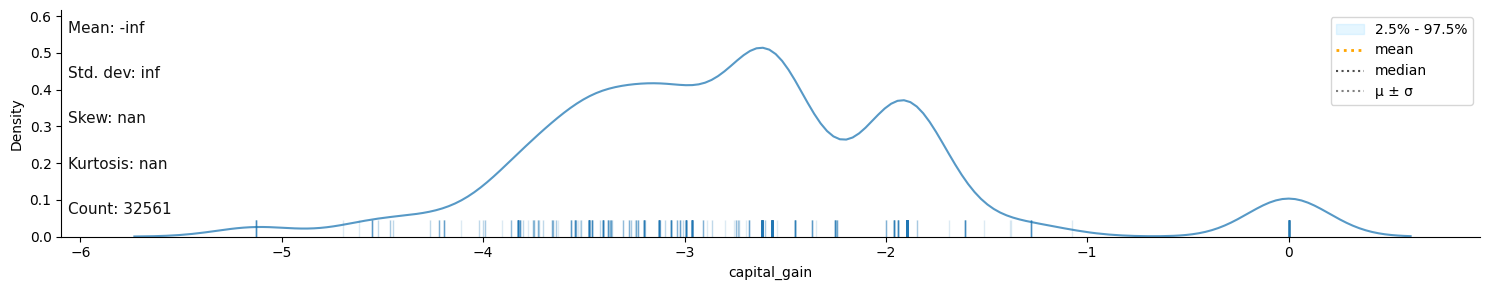

In [26]:
import klib
import pandas as pd
klib.dist_plot(adult['capital_gain'])

In [ ]:
adult['capital_gain'] = adult['capital_gain'].replace(-np.inf, np.nan)
min_value = adult['capital_gain'].min()
adult['capital_gain'] = adult['capital_gain'].fillna(min_value)
adult.head()

In [ ]:
klib.dist_plot(adult['capital_gain'])

# Why Log Transformation for "Capital Gain"?

The "capital_gain" feature, being highly skewed, likely has many small values and a few very large values. Applying a log transformation can help reduce this skew, making the distribution more normal-like (Gaussian), which many models prefer.

In [29]:
from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(adult)
yhat

array([ 1,  1,  1, ...,  1,  1, -1])

In [ ]:
mask = yhat != -1
adult = adult[mask]
adult.head()

Outliers can distort model performance, leading to overfitting, increased variance, and poor generalization.

Removing outliers can result in a more robust and accurate model, as it allows the model to focus on the general pattern of the data without being misled by extreme values.

In [ ]:
!pip install ppscore

In [ ]:
import ppscore as pps
pp_score = pps.matrix(adult)
pp_score

In [ ]:
pp_corr = pd.pivot_table(pp_score, index='x', columns='y', values='ppscore')
pp_corr

In [ ]:
plt.figure(figsize=(16,12))
sns.heatmap(pp_corr,annot=True,fmt=".2f")

In [ ]:
corr = adult.corr()
corr

In [ ]:
plt.figure(figsize=(16,12))
sns.heatmap(corr,annot=True,fmt=".2f")

### Comparison and Discussion

##### Predictive Power vs. Correlation:

Both matrices indicate that features like education_num and age are influential in predicting higher income (>50K). However, the PPS matrix provides insights into the predictive power of these features more directly.

Features like workclass and native_country have low predictive power in the PPS matrix, and this is consistent with their low or negligible correlations in the correlation matrix.

##### Features with High Correlation but Low Predictive Power:

age and work_experience have a high correlation (0.983121), but work_experience has only a moderate predictive power score (0.173629). This suggests that while age and work_experience are related, the latter's contribution to predicting income above $50K is less significant.

##### Feature Relationships:

The correlation matrix shows how features like education_num and education are perfectly correlated, which makes sense as higher education generally translates to higher education numbers.

Negative correlations such as marital_status and relationship with >50K in the correlation matrix indicate that the impact of these features on income might be complex and dependent on other interacting features.